# Model Training Using Lisitngs Enhanced With Hexagons

In [34]:
import pandas as pd
import snowflake.connector
import os
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import boto3

## 1. Import Data
#### 1.1 Load Snowflake credentials for temp user

In [2]:
# Load environment variables from a .env file
load_dotenv()

try:
    TEMP_USER = os.getenv('SNOWSQL_TEMP_USER')
    TEMP_USER_PASSWORD = os.getenv('SNOWSQL_TEMP_PWD')
    ACCOUNT = os.getenv('SNOWFLAKE_ACCOUNT')
    
    if not TEMP_USER:
        raise ValueError("Environment variable SNOWSQL_TEMP_USER must be set")
    if not TEMP_USER_PASSWORD:
        raise ValueError("Environment variable SNOWSQL_TEMP_PWD must be set")

except ValueError as ve:
    print(f"Error: {ve}")
    
except Exception as e:
    print(f"An unexpected error occurred: {e}")

#### 1.2 Connect to Snowflake

In [3]:
# Establish connection to Snowflake
current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')

try:
    conn = snowflake.connector.connect(
        user=TEMP_USER,
        password=TEMP_USER_PASSWORD,
        account=ACCOUNT,
        warehouse='COMPUTE_WH',
        database='AIRBNB',
        schema='FEATURE_STORE'
    )

    print(f'Connected to Snowflake successfully at {current_time}')

except Exception as e:
    print(f'Failed to connect to Snowflake on {current_time} due to error code {e}')

Connected to Snowflake successfully at 2024-08-05 20:3029


In [4]:
def get_data(sql_query, date_columns=None):
    """
    Executes a SQL query and returns the result as a pandas DataFrame.

    Args:
        sql_query (str): SQL query to execute.

    Returns:
        df_result: Resulting DataFrame from the SQL query.
    """
    try:
        cursor = conn.cursor()
        
        cursor.execute(sql_query)

        # load data into dataframe
        df_result = cursor.fetch_pandas_all()

        # Convert column names to lowercase
        df_result.columns = map(str.lower, df_result.columns)

        # Parse specified date columns
        if date_columns:
            for col in date_columns:
                df_result[col] = pd.to_datetime(df_result[col], errors='coerce')

    finally:
        if cursor is not None:
            cursor.close()

    return df_result

#### 1.3 Load data from `listings_cleaned_h3` table

In [5]:
sql_query = '''
select * from listings_cleaned_h3
 '''

df = get_data(sql_query)
df.shape

(77425, 12)

In [6]:
df.head()

,market,room_type,accommodates,bathrooms,beds,latitude,longitude,price,accommodates_median,bathrooms_median,bedrooms_median,price_median
0,albany,Private room,2,1.0,0.0,42.66719,-73.81580,50.0,2.0,1.0,1.0,56.0
1,albany,Entire home/apt,2,1.0,1.0,42.65222,-73.76724,118.0,3.0,1.0,1.0,103.0
2,albany,Entire home/apt,2,1.0,1.0,42.64615,-73.75966,90.0,3.0,1.0,1.0,105.0
3,albany,Entire home/apt,2,1.0,1.0,42.65222,-73.76724,120.0,3.0,1.0,1.0,103.0
4,albany,Private room,2,2.5,1.0,42.66063,-73.78115,199.0,2.0,1.0,1.0,100.0


## 2. Feature Engineering
#### 2.1 One-hot encoding

In [7]:
# Separate features and target
X = df.drop(columns=['price','latitude','longitude'], axis=1)
y = df['price']

# Perform one-hot encoding on categorical features
X_encoded = pd.get_dummies(X, columns=['market', 'room_type'])

#### 2.2 Correlation analysis of features

In [8]:
# Separate features and target
X = df.drop(columns=['price','latitude','longitude'], axis=1)
y = df['price']

# Perform one-hot encoding on categorical features
X_encoded = pd.get_dummies(X, columns=['market', 'room_type'])

# Combine encoded features with the target variable
df_encoded = X_encoded.copy()
df_encoded['price'] = y

# Calculate correlations
correlations = df_encoded.corr()

# Display correlations with the price column
print(correlations['price'].sort_values(ascending=False))

price                        1.000000
accommodates                 0.522963
room_type_Entire home/apt    0.435752
price_median                 0.417356
beds                         0.406491
bathrooms                    0.298986
market_los-angeles           0.097593
accommodates_median          0.059703
bathrooms_median             0.049947
bedrooms_median              0.040974
market_new-york-city         0.019965
room_type_Hotel room         0.014075
market_san-francisco        -0.004333
market_albany               -0.035376
market_washington-dc        -0.038454
market_seattle              -0.059253
market_chicago              -0.104767
room_type_Shared room       -0.106532
room_type_Private room      -0.417634
Name: price, dtype: float64


price_median provides a useful aggregate measure of the price within the same spatial cluster (hexagon). Its moderate positive correlation with the price of individual listings indicates that it is a relevant feature for predicting prices. price_median provides contextual information about the pricing environment within each hexagon. Even if individual listing prices vary, the median price of listings within the same spatial cluster can help capture local pricing trends and market conditions.

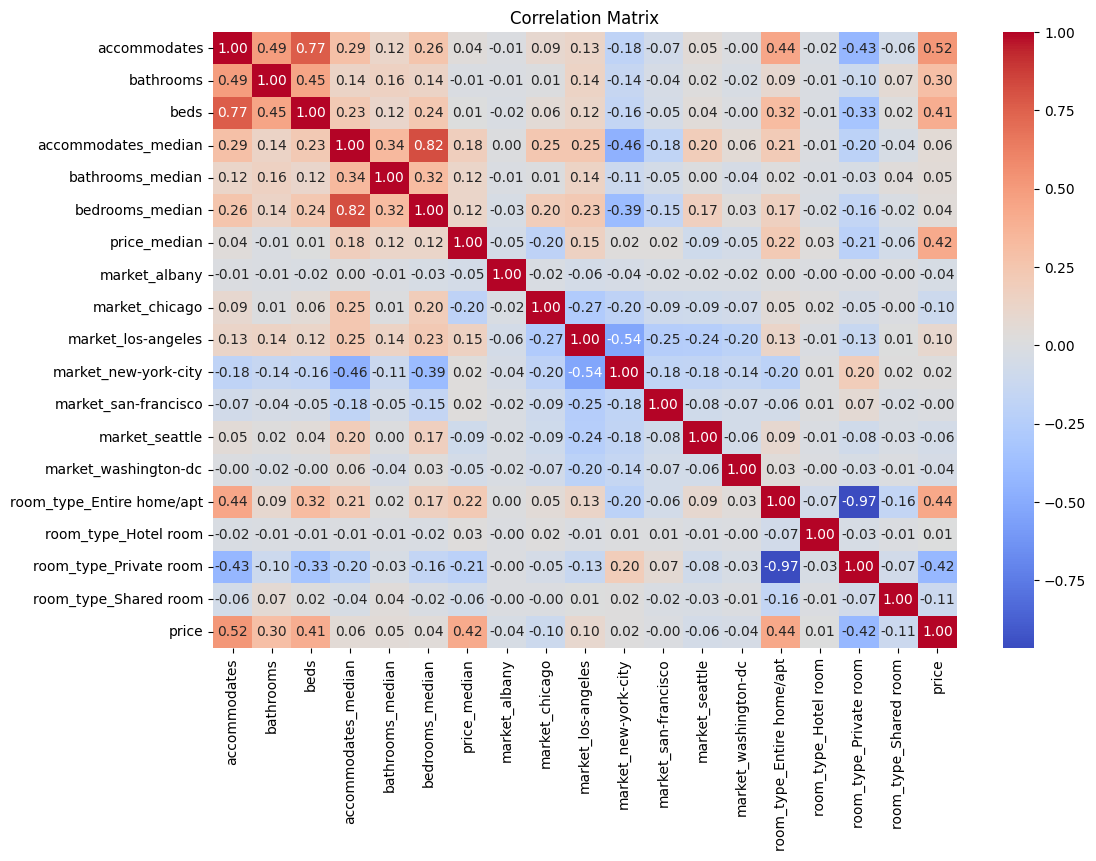

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### 2.3 Standardize numerical features

In [10]:
df.dtypes

market                  object
room_type               object
accommodates              int8
bathrooms              float64
beds                   float64
latitude               float64
longitude              float64
price                  float64
accommodates_median    float64
bathrooms_median       float64
bedrooms_median        float64
price_median           float64
dtype: object

In [11]:
# Separate numerical features
numerical_features = X_encoded[['accommodates', 'bathrooms', 'beds']]

# Target variable
y = df['price']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
standardized_features = scaler.fit_transform(numerical_features)

# Convert the result to a DataFrame
standardized_features_df = pd.DataFrame(standardized_features, columns=numerical_features.columns)

# Combine standardized features with the target variable
df_standardized = pd.concat([standardized_features_df, y], axis=1)

## 3. Model Training
#### 3.1 Create training pipeline

In [14]:
# Define features and target
X = df.drop(columns=['price', 'latitude', 'longitude'])
y = df['price']

# Define categorical and numerical features
categorical_features = ['market', 'room_type']
numerical_features = ['accommodates', 'bathrooms', 'beds','accommodates_median','bathrooms_median','bedrooms_median','price_median']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor()) 
])

#### 3.2 Define parameters for Randomized Search

In [18]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4, 6]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of random combinations to try
    cv=5,       # Number of cross-validation folds
    scoring='neg_mean_absolute_error',  # Use mean absolute error
    n_jobs=-1,  # Use all available cores
    verbose=2,  # Print progress
    random_state=42
)

#### 3.3 Split data into training and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=42)

#### 3.4 Perform Randomized Search using Mean Absolute Error

In [20]:
# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['accommodates',
                                                                                'bathrooms',
                                                                                'beds',
                                                                                'accommodates_median',
                                                                                'bathrooms_median',
                                                                                'bedrooms_median',
                                                                                'price_median']),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               ['market',
                                                                                'room_type'])])),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 10, 20, 30,
                                                             40],
                                        'model__min_samples_leaf': [1, 2, 4, 6],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     15],
                                        'model__n_estimators': [50, 100, 150,
                                                                200]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [21]:
# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'model__n_estimators': 200, 'model__min_samples_split': 15, 'model__min_samples_leaf': 1, 'model__max_depth': 20}
Best score found:  -41.585887031983944


In [22]:
# Predict and evaluate using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

#### 3.4 Model Evaluation

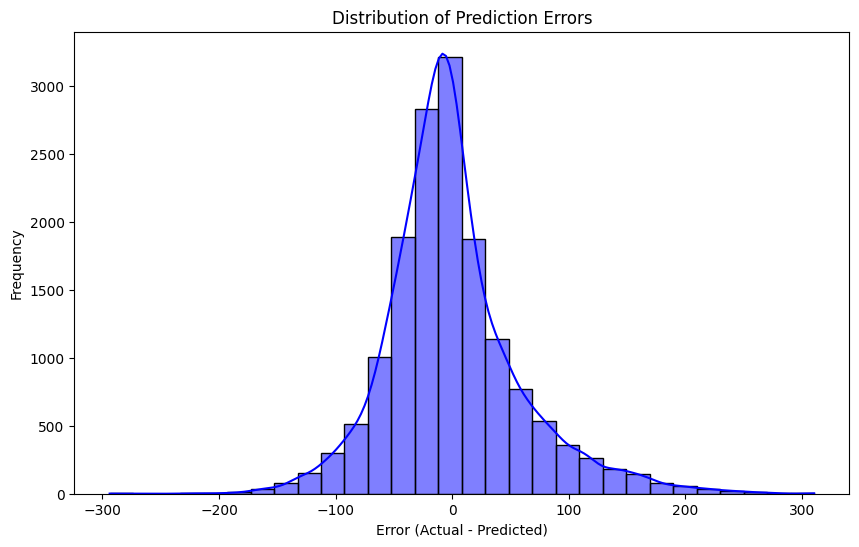

Mean Absolute Error: 41.58
Root Mean Squared Error: 57.76
R² Score: 0.57


In [28]:
# Calculate residuals (errors)
errors = y_test - y_pred

# Create a dataframe
errors_df = pd.DataFrame({'Error': errors})

# Plot the distribution of errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_df['Error'], kde=True, bins=30, color='blue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

## 4. Export Model
#### 4.1 Save the model locally

In [32]:
from joblib import dump

# Save the model locally
dump(best_model, 'model_h3.joblib')

['model_h3.joblib']

#### 4.2 Save the model to AWS S3

In [35]:
# boto3 will initialize connection using environment variables
s3 = boto3.resource('s3')

In [37]:
bucket_name = 'airbnb-capstone-project'
file_name = 'model_h3.joblib'
s3_file_name = 'models/model_h3.joblib'

# Initialize S3 client
s3 = boto3.client('s3')

try:
    # Upload the file
    s3.upload_file(file_name, bucket_name, s3_file_name)
    print(f"Model saved and uploaded successfully to s3://{bucket_name}/{s3_file_name}")
except FileNotFoundError:
    print(f"The file {file_name} was not found.")

Model saved and uploaded successfully to s3://airbnb-capstone-project/models/model_h3.joblib
